# Global Energy Monitor 

This notebook downloads, explores, cleans, and processes the Global Energy Monitor dataset on solar power plants.

## Setup

In [42]:
pip install plotly ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [43]:
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

## Download data

In [44]:
# The URL is received by email 
# Todo : get the new link automatically when the dataset is updated 

url = "https://globalenergymonitor.org/wp-content/uploads/2025/02/Global-Solar-Power-Tracker-February-2025.xlsx"

In [45]:
# output path
output_folder = os.path.join("..", "..", "data", "raw_data")
os.makedirs(output_folder, exist_ok=True)

filename = url.split("/")[-1]
filepath = os.path.join(output_folder, filename)

In [46]:
# Download the file
print("Downloading dataset...")
response = requests.get(url)
with open(filepath, "wb") as f:
    f.write(response.content)
print("✅ Downloaded:", filename)

✅ Downloaded: Global-Solar-Power-Tracker-February-2025.xlsx


In [47]:
print("\nLoading Excel file into pandas...")
xls = pd.ExcelFile(filepath)
print("Available sheets:", xls.sheet_names)


Loading Excel file into pandas...
Available sheets: ['About', '20 MW+', '1-20 MW']


In [48]:
# Load the two sheets (20 MW+ and 1-20MW) into one DataFrames

df_20mw_plus = xls.parse('20 MW+')
df_1_20mw = xls.parse('1-20 MW')

df_merged = pd.concat([df_20mw_plus, df_1_20mw], ignore_index=True)
df_china = df_merged[df_merged['Country/Area'].str.lower().str.contains('china','hong kong', na=False)].reset_index(drop=True)

## Clean

In [49]:
df_china.head()

,Date Last Researched,Country/Area,Project Name,Phase Name,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,"Local area (taluk, county)","Major area (prefecture, district)",State/Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
0,2024/08/26,China,Alxa Left Banner-Wide (Jiangneng) Distributed ...,--,阿拉善左旗125.93MW整旗（县）屋项分布式光伏开发示范项目,NaN,126.0,unknown,PV,pre-construction,NaN,NaN,NaN,NaN,Jiangneng (Alxa League) New Energy Technology ...,疆能（阿拉善盟） 新能源科技有限公司,NaN,38.8350,105.6840,approximate,NaN,Alxa Left Bannner,Alxa League,Inner Mongolia,Eastern Asia,Asia,L100001019972,G100001022676,NaN,NaN,https://www.gem.wiki/Alxa_Left_Banner-Wide_(Ji...
1,2024/07/26,China,Anhui Anqing Gaoxin Jidian solar farm,1,安庆市高新区光伏发电一期项目,安庆市高新区园区级源网荷储一体化试点项目,60.0,unknown,PV,pre-construction,NaN,NaN,Anqing High Tech Jidian Energy,安庆高新吉电能源有限公司,Jilin Electric Power Co Ltd ; Anqing Chemical ...,安庆化工建设投资有限公司; 吉林电力股份有限公司,NaN,30.5450,117.0642,approximate,NaN,Gaoxin District,Anqing,Anhui,Eastern Asia,Asia,L100000809174,G100000811521,NaN,NaN,https://www.gem.wiki/Anhui_Anqing_Gaoxin_Jidia...
2,2024/07/26,China,Anhui Anqing Gaoxin Jidian solar farm,2,安庆市高新区光伏发电二期项目,安庆市高新区园区级源网荷储一体化试点项目,40.0,unknown,PV,announced,NaN,NaN,Anqing High Tech Jidian Energy,安庆高新吉电能源有限公司,Jilin Electric Power Co Ltd ; Anqing Chemical ...,安庆化工建设投资有限公司; 吉林电力股份有限公司,NaN,30.5450,117.0642,approximate,NaN,Gaoxin District,Anqing,Anhui,Eastern Asia,Asia,L100000809174,G100000811522,NaN,NaN,https://www.gem.wiki/Anhui_Anqing_Gaoxin_Jidia...
3,2022/03/01,China,Anhui Anqing Wanhe Farm solar farm,--,安徽省安庆皖河农场光伏发电项目,NaN,200.0,unknown,PV,operating,2022.0,NaN,Guoneng Shenwan (Anqing) New Energy,国能神皖（安庆）新能源有限责任公司,CLP Asset Management Co Ltd ; Shenwan Energy C...,中电资产管理有限公司; 国能神皖能源有限责任公司,NaN,30.4801,116.9478,approximate,Haikou Town,Daguan District,Anqing,Anhui,Eastern Asia,Asia,L100000809175,G100000811523,NaN,NaN,https://www.gem.wiki/Anhui_Anqing_Wanhe_Farm_s...
4,2024/07/08,China,Anhui Bengbu Nihe solar farm,--,蚌埠市泥黑河渔光互补项目,NaN,180.0,unknown,PV,announced,NaN,NaN,Guoneng Shenwan Chizhou Power Generation,国能神皖池州发电有限责任公司,NaN,NaN,NaN,32.9095,116.8071,approximate,NaN,Huaiyuan,Bengbu,Anhui,Eastern Asia,Asia,L100001018482,G100001020633,NaN,NEA:,https://www.gem.wiki/Anhui_Bengbu_Nihe_solar_farm


In [50]:
df_china.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16658 entries, 0 to 16657
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date Last Researched                      16658 non-null  object 
 1   Country/Area                              16658 non-null  object 
 2   Project Name                              16658 non-null  object 
 3   Phase Name                                16658 non-null  object 
 4   Project Name in Local Language / Script   16388 non-null  object 
 5   Other Name(s)                             3122 non-null   object 
 6   Capacity (MW)                             16658 non-null  float64
 7   Capacity Rating                           16658 non-null  object 
 8   Technology Type                           16658 non-null  object 
 9   Status                                    16658 non-null  object 
 10  Start year                        

In [51]:
df_china.describe()

,Capacity (MW),Start year,Retired year,Latitude,Longitude
count,16658.000000,10953.000000,1.0,16658.000000,16658.000000
mean,74.367835,2017.865425,2017.0,33.369512,112.573910
std,238.729635,2.865369,NaN,5.834055,9.279178
min,1.000000,2008.000000,2017.0,18.301100,73.925800
25%,3.000000,2016.000000,2017.0,29.207300,108.862500
50%,20.000000,2017.000000,2017.0,33.000000,115.409300
75%,90.000000,2019.000000,2017.0,37.595100,119.411800
max,8500.000000,2030.000000,2017.0,50.232200,132.432500


### Delete duplicate 

In this dataset, a duplicate is not a simple exact copy of a row, but rather multiple entries referring to different phases of the same solar project. These duplicates usually share the same project name, location, url... However they can differ by phase number or capacity

To simply the dataset while preserving the most relevant information we keep only the last project phase per solar-projetc as it reflects the most up-to-date status.

In [52]:
# Keep only the duplicates
df_duplicates = df_china.groupby('Wiki URL').filter(lambda x: len(x) > 1)
df_duplicates.head()

,Date Last Researched,Country/Area,Project Name,Phase Name,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,"Local area (taluk, county)","Major area (prefecture, district)",State/Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
1,2024/07/26,China,Anhui Anqing Gaoxin Jidian solar farm,1,安庆市高新区光伏发电一期项目,安庆市高新区园区级源网荷储一体化试点项目,60.0,unknown,PV,pre-construction,NaN,NaN,Anqing High Tech Jidian Energy,安庆高新吉电能源有限公司,Jilin Electric Power Co Ltd ; Anqing Chemical ...,安庆化工建设投资有限公司; 吉林电力股份有限公司,NaN,30.5450,117.0642,approximate,NaN,Gaoxin District,Anqing,Anhui,Eastern Asia,Asia,L100000809174,G100000811521,NaN,NaN,https://www.gem.wiki/Anhui_Anqing_Gaoxin_Jidia...
2,2024/07/26,China,Anhui Anqing Gaoxin Jidian solar farm,2,安庆市高新区光伏发电二期项目,安庆市高新区园区级源网荷储一体化试点项目,40.0,unknown,PV,announced,NaN,NaN,Anqing High Tech Jidian Energy,安庆高新吉电能源有限公司,Jilin Electric Power Co Ltd ; Anqing Chemical ...,安庆化工建设投资有限公司; 吉林电力股份有限公司,NaN,30.5450,117.0642,approximate,NaN,Gaoxin District,Anqing,Anhui,Eastern Asia,Asia,L100000809174,G100000811522,NaN,NaN,https://www.gem.wiki/Anhui_Anqing_Gaoxin_Jidia...
5,2024/07/26,China,Anhui Bengbu Wuhe (Yaoyang) solar farm,1,五河耀洋一期渔光互补光伏发电项目,蚌埠市五河县风光储一体化试点项目,200.0,unknown,PV,operating,2024.0,NaN,Wuhe Yaoyang New Energy Technology,五河耀洋新能源科技有限公司,Bengbu Linyang New Energy Technology Co Ltd,蚌埠林洋新能源科技有限公司,NaN,33.2967,117.8971,approximate,Wuqiao Town,Wuhe,Bengbu,Anhui,Eastern Asia,Asia,L100000809176,G100000811524,NaN,NaN,https://www.gem.wiki/Anhui_Bengbu_Wuhe_(Yaoyan...
6,2024/07/26,China,Anhui Bengbu Wuhe (Yaoyang) solar farm,2,五河耀洋二期渔光互补光伏发电项目,蚌埠市五河县风光储一体化试点项目,250.0,unknown,PV,pre-construction,NaN,NaN,Wuhe Yaoyang New Energy Technology,五河耀洋新能源科技有限公司,Bengbu Linyang New Energy Technology Co Ltd,蚌埠林洋新能源科技有限公司,NaN,33.2967,117.8971,approximate,Wuqiao Town,Wuhe,Bengbu,Anhui,Eastern Asia,Asia,L100000809176,G100000811525,NaN,NaN,https://www.gem.wiki/Anhui_Bengbu_Wuhe_(Yaoyan...
7,2024/07/26,China,Anhui Bengbu Wuhe (Yaoyang) solar farm,3,五河耀洋三期渔光互补光伏发电项目,蚌埠市五河县风光储一体化试点项目,350.0,MWp/dc,PV,pre-construction,NaN,NaN,Wuhe Yaoyang New Energy Technology,五河耀洋新能源科技有限公司,Bengbu Linyang New Energy Technology Co Ltd,蚌埠林洋新能源科技有限公司,NaN,33.2967,117.8971,approximate,Wuqiao Town,Wuhe,Bengbu,Anhui,Eastern Asia,Asia,L100000809176,G100000811526,NaN,NaN,https://www.gem.wiki/Anhui_Bengbu_Wuhe_(Yaoyan...


We observe that the most up-to-date phase is usually the one marked as "1" (e.g., "operating" vs "pre-construction"). Therefore, this is the phase we will keep. However, sometimes earlier phases contain more detailed information—for example, the capacity rating might be listed as "unknown" in the latest phase but specified as "MWp/dc" in a previous one. In such cases, we combine the data to retain the most complete information.  

In [53]:
# Rename 'Phase Name' to 'Phase'
df_china = df_china.rename(columns={'Phase Name': 'Phase'})

# Convert to numeric, coercing errors to NaN
df_china['Phase'] = pd.to_numeric(df_china['Phase'], errors='coerce')

In [54]:
# Sort by Phase ascending so earliest phase comes first
df_china_sorted = df_china.sort_values('Phase')

# Drop duplicates keeping only the first for each Wiki URL
df_china_unique = df_china_sorted.drop_duplicates(subset=['Wiki URL'], keep='first').reset_index(drop=True)

In [55]:
df_china_unique.head()

,Date Last Researched,Country/Area,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,Start year,Retired year,Operator,Operator Name in Local Language / Script,Owner,Owner Name in Local Language / Script,Hydrogen,Latitude,Longitude,Location accuracy,City,"Local area (taluk, county)","Major area (prefecture, district)",State/Province,Subregion,Region,GEM location ID,GEM phase ID,Other IDs (location),Other IDs (unit/phase),Wiki URL
0,2024/07/26,China,Anhui Anqing Gaoxin Jidian solar farm,1.0,安庆市高新区光伏发电一期项目,安庆市高新区园区级源网荷储一体化试点项目,60.0,unknown,PV,pre-construction,NaN,NaN,Anqing High Tech Jidian Energy,安庆高新吉电能源有限公司,Jilin Electric Power Co Ltd ; Anqing Chemical ...,安庆化工建设投资有限公司; 吉林电力股份有限公司,NaN,30.5450,117.0642,approximate,NaN,Gaoxin District,Anqing,Anhui,Eastern Asia,Asia,L100000809174,G100000811521,NaN,NaN,https://www.gem.wiki/Anhui_Anqing_Gaoxin_Jidia...
1,2024/06/05,China,Inner Mongolia Kubuqi Desert Base Ordos New En...,1.0,库布齐沙漠基地鄂尔多斯新能源170万千瓦光伏项目,库布齐沙漠400万千瓦新能源项目,600.0,MWac,PV,construction,NaN,NaN,Inner Mongolia Jingneng Junggar Banner New Energy,内蒙古京能准旗新能源有限公司,NaN,NaN,NaN,40.0770,110.9578,exact,Buertaohai Town,Jungar Banner,Ordos,Inner Mongolia,Eastern Asia,Asia,L100000828449,G100000832109,NaN,NaN,https://www.gem.wiki/Inner_Mongolia_Kubuqi_Des...
2,2025/01/10,China,"Xinjiang Alar Textile Park ""Source/Grid/Load/S...",1.0,一师阿拉尔纺织产业园源网荷储项目一期10万千瓦光伏发电项目,NaN,100.0,MWac,PV,operating,2024.0,NaN,NaN,NaN,State Power Investment Group Xinjiang Energy a...,国家电投集团新疆能源化工有限责任公司,NaN,40.5440,81.3520,approximate,10th Division of 1st Regiment of Xinjiang Prod...,Alar City,NaN,Xinjiang,Eastern Asia,Asia,L100000828950,G100000832697,NaN,NaN,https://www.gem.wiki/Xinjiang_Alar_Textile_Par...
3,2022/03/01,China,Inner Mongolia Kubuqi Desert (China Guangdong ...,1.0,中广核内蒙古库布齐沙漠朔方光伏电站,Inner Mongolia Kubuqi Shuofang solar power pla...,200.0,MWp/dc,PV,operating,2018.0,NaN,NaN,NaN,CGN New Energy Investment (Shenzhen) CO LTD In...,中广核新能源投资（深圳）有限公司内蒙古分公司,NaN,43.2443,114.3252,approximate,Duguitala Town,Hanggin Banner,Ordos,Inner Mongolia,Eastern Asia,Asia,L100000810657,G100000813090,NaN,NaN,https://www.gem.wiki/Inner_Mongolia_Kubuqi_Des...
4,2022/03/01,China,Xinjiang Alar Tianhua Sunshine Grid-Connected ...,1.0,阿拉尔天华阳光新能源新疆兵团农一师十团十一连一期30.0MW发电工程,NaN,30.0,unknown,PV,operating,2012.0,NaN,Alar Tianhua Sunshine New Energy Power,阿拉尔天华阳光新能源电力有限公司,Huaneng Xinjiang Energy Develop Co Ltd,华能新疆能源开发有限公司,NaN,40.6914,81.2626,approximate,NaN,Alar City,NaN,Xinjiang,Eastern Asia,Asia,L100000802264,G100000802708,NaN,NaN,https://www.gem.wiki/Xinjiang_Alar_Tianhua_Sun...


In [56]:
df_china_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15492 entries, 0 to 15491
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date Last Researched                      15492 non-null  object 
 1   Country/Area                              15492 non-null  object 
 2   Project Name                              15492 non-null  object 
 3   Phase                                     1550 non-null   float64
 4   Project Name in Local Language / Script   15274 non-null  object 
 5   Other Name(s)                             2838 non-null   object 
 6   Capacity (MW)                             15492 non-null  float64
 7   Capacity Rating                           15492 non-null  object 
 8   Technology Type                           15492 non-null  object 
 9   Status                                    15492 non-null  object 
 10  Start year                        

In [57]:
unique_url_count = df_china['Wiki URL'].nunique()
print("Number of unique Wiki URLs:", unique_url_count)

Number of unique Wiki URLs: 15492


### Validation

In [58]:
capacity_by_year = df_china.groupby("Start year")["Capacity (MW)"].sum()

cumulative_capacity = capacity_by_year.cumsum()

capacity = pd.DataFrame({
    "Annual Capacity (MW)": capacity_by_year,
    "Cumulative Capacity (MW)": cumulative_capacity
})

capacity

,Annual Capacity (MW),Cumulative Capacity (MW)
Start year,,
2008.0,1.0,1.0
2009.0,10.0,11.0
2010.0,105.8,116.8
2011.0,1013.5,1130.3
2012.0,1997.0,3127.3
2013.0,7988.6,11115.9
2014.0,10609.5,21725.4
2015.0,15019.1,36744.5
2016.0,32146.8,68891.3


According the official statitics published by [Chinese Energy Portail](https://chinaenergyportal.org/en/2021-electricity-other-energy-statistics-preliminary/) China’s newly installed photovoltaic (PV) capacity in recent years was as follows:
- **2019** : 30 350 MW
- **2020** : 56 420 MW
- **2021** : 45 460 MW

The total installed PV capacity recorded in the dataset is different than the official national figures.We should be careful when using the dataset. This difference can comes from the fact that the dataset focuses on utility-scale solar power plants, while household and other small-scale distributed PV systems are not included.

We have as many URLs as there are rows, meaning each row corresponds to a unique project.

### Save preprocessed data

In [59]:
output_dir = "../../data/data_processed"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "GEM_processed.csv")

# Enregistre le DataFrame
df_china_unique.to_csv(output_path, index=False)

## Exploratory analysis

In [60]:
df= pd.read_csv("../../data/data_processed/GEM_processed.csv")


### Capacity

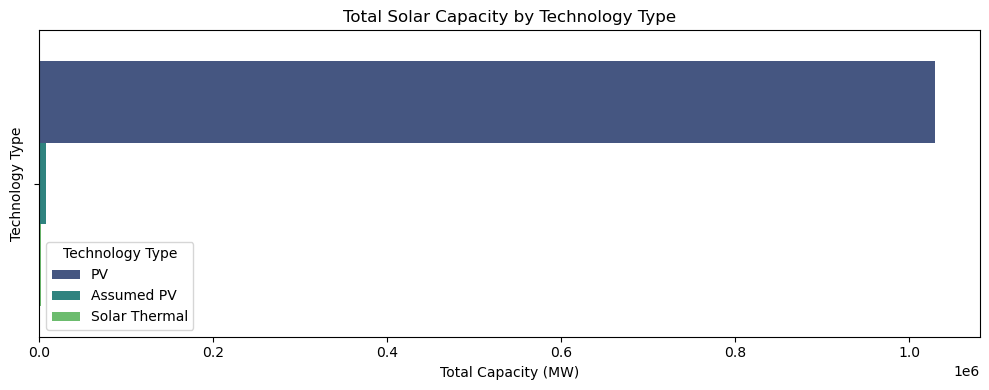

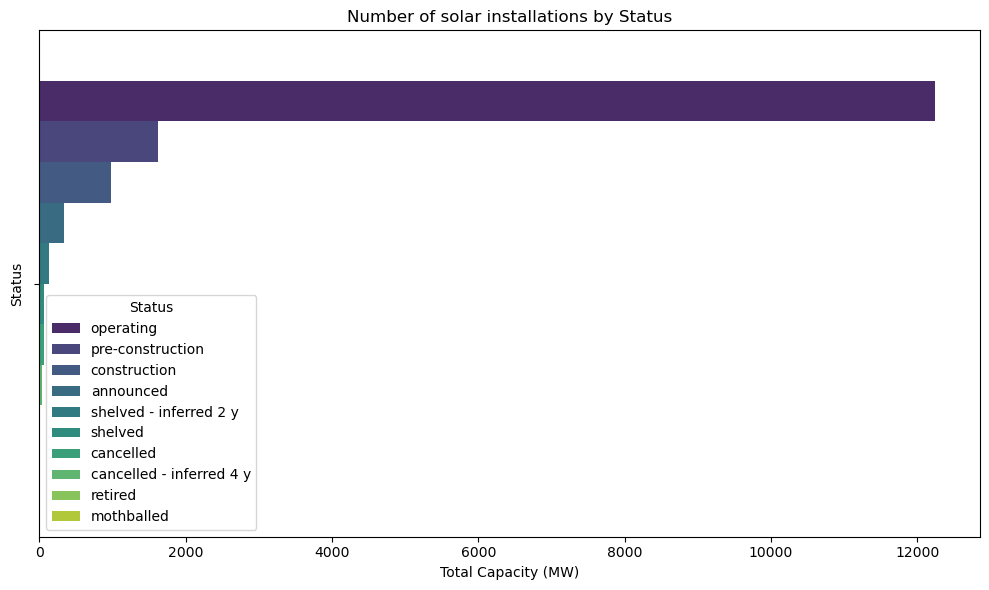

In [61]:
plt.figure(figsize=(10, 4))
tech_grouped = df.groupby("Technology Type")["Capacity (MW)"].sum().sort_values(ascending=False).reset_index()
sns.barplot(data= tech_grouped, x="Capacity (MW)", hue="Technology Type", palette="viridis")
plt.title("Total Solar Capacity by Technology Type")
plt.xlabel("Total Capacity (MW)")
plt.ylabel("Technology Type")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
province_grouped = df.groupby("Status")["Capacity (MW)"].count().sort_values(ascending=False).reset_index()
sns.barplot(data= province_grouped, x="Capacity (MW)", hue="Status", palette="viridis")
plt.title("Number of solar installations by Status")
plt.xlabel("Total Capacity (MW)")
plt.ylabel("Status")
plt.tight_layout()
plt.show()



### Geographical visualization

In [62]:
current_year = datetime.today().year
df = df[df['Start year'] <= current_year]

In [63]:
group_by_dropdown = widgets.Dropdown(
    options=["Technology Type", "Status", "Start year"],
    value="Technology Type",
    description="Group by:",
)

def update_scatterplot(group_by):

    #Legend color
    unique_vals = df[group_by].nunique()
    palette = sns.color_palette("husl", n_colors=unique_vals)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="Longitude",
        y="Latitude",
        size="Capacity (MW)",
        hue=group_by,
        alpha=0.6,
        sizes=(10, 500),  # you can adjust the min/max size of points
        palette= palette
    )
    plt.title(f"Geographic Distribution of Solar Projects by {group_by}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

widgets.interact(update_scatterplot, group_by = group_by_dropdown)

interactive(children=(Dropdown(description='Group by:', options=('Technology Type', 'Status', 'Start year'), v…

<function __main__.update_scatterplot(group_by)>

In [64]:
geo_dropdown = widgets.Dropdown(
    options=[
        'State/Province',
        'Major area (prefecture, district)',
        'Local area (taluk, county)'
    ],
    value='State/Province',
    description='Group by:',
)

def update_map(geo_level):
    # # Aggregate capacity by Year, geographic zone
    df_agg = df.groupby(['Start year', geo_level]).agg({
        'Capacity (MW)': 'sum',
        'Latitude': 'mean',
        'Longitude': 'mean'
    }).reset_index()

    # Cumulative capacity
    df_agg['Cumulative Capacity (MW)'] = df_agg.groupby(geo_level)['Capacity (MW)'].cumsum()

    min_capacity = df_agg['Cumulative Capacity (MW)'].min()
    max_capacity = df_agg['Cumulative Capacity (MW)'].max()

    fig = px.density_mapbox(
        df_agg,
        lat='Latitude',
        lon='Longitude',
        z='Cumulative Capacity (MW)',
        radius=50,
        animation_frame='Start year',
        color_continuous_scale='Viridis',
        range_color=[min_capacity, max_capacity],
        mapbox_style='carto-positron',
        hover_name=geo_level,
        title=f'Solar Capacity Density by {geo_level} Over Time',
        zoom=3,
        height=700,
        width=1000,
    )

    fig.show()

widgets.interact(update_map, geo_level=geo_dropdown)


interactive(children=(Dropdown(description='Group by:', options=('State/Province', 'Major area (prefecture, di…

<function __main__.update_map(geo_level)>